In [1]:
import tslearn
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tslearn.clustering import TimeSeriesKMeans, silhouette_score
from tslearn import metrics
from tslearn.preprocessing import TimeSeriesScalerMinMax
from sklearn.decomposition import PCA
import warnings
warnings.filterwarnings('ignore')

I used Weights&Biases on this notebook to monitor and track the performance of k-means 

In [2]:
import wandb
wandb.init(project="tscluster", entity="pillarxyz")

config = wandb.config
config.seed = 42
config.metric = 'dtw'
config.n_clusters = 4
config.run_pca = False
np.random.seed(config.seed)
wandb.config.update(config)

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: pillarxyz (use `wandb login --relogin` to force relogin)


In [3]:
%env "WANDB_NOTEBOOK_NAME" "tscluster"

env: "WANDB_NOTEBOOK_NAME"="tscluster"


# Reading Data

In [4]:
stocks_df = pd.read_csv("data/stocks.csv")

the dataset consists of closing prices of over 70 moroccan stocks including the MASI index

In [5]:
stocks_df

,date,Addoha,AFMA,Afric Indus,Afriquia Gaz,Agma,Alliances,Aluminium Maroc,Aradei Capital,ATLANTASANAD,...,SRM,Ste Boissons,STROC Indus,TAQA Morocco,Timar,Total Maroc,Unimer,Wafa Assur,Zellidja,MASI
0,16/01/2017,54.87,822.5,315.35,NaN,NaN,128.00,1150.0,NaN,49.00,...,284.00,2350.0,56.99,804.0,276.00,1450.0,NaN,4850.0,122.00,12576.9549
1,17/01/2017,51.50,822.5,315.35,NaN,NaN,128.55,1150.0,NaN,49.40,...,284.00,2300.0,59.00,790.0,292.55,1402.0,NaN,4851.0,122.00,12343.0822
2,18/01/2017,52.00,823.0,320.00,NaN,NaN,130.00,1150.0,NaN,47.86,...,284.00,2300.0,60.50,790.0,292.50,1411.0,NaN,4800.0,122.00,12379.0624
3,19/01/2017,52.00,805.1,300.00,NaN,NaN,131.45,1180.0,NaN,49.90,...,283.85,2350.0,54.46,795.0,275.00,1478.0,NaN,4840.0,122.00,12425.0963
4,20/01/2017,53.00,830.0,295.00,NaN,2460.0,131.00,1150.0,NaN,49.00,...,283.85,2350.0,56.39,810.0,259.05,1499.0,NaN,4800.0,129.30,12592.5336
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1239,12/01/2022,11.40,1350.0,345.00,5404.0,4550.0,39.00,1428.0,415.00,136.50,...,147.00,2859.0,43.20,1104.0,141.00,1750.0,142.0,4707.0,76.95,13531.2560
1240,13/01/2022,11.58,1350.0,353.20,5351.0,4500.0,39.00,1425.0,419.95,135.85,...,147.00,2859.0,42.20,1140.0,141.00,1770.0,142.0,4571.0,80.02,13588.2416
1241,14/01/2022,11.52,1350.0,350.00,5410.0,4500.0,38.90,1425.0,420.00,136.00,...,147.00,2980.0,43.38,1162.0,141.00,1805.0,142.0,4845.0,80.02,13784.3063
1242,17/01/2022,11.51,1350.0,350.00,5410.0,4679.0,38.38,1424.0,422.10,134.00,...,147.00,2980.0,43.33,1215.0,141.00,1800.0,142.0,4845.0,80.02,13770.7843


### Formatting the date column

In [6]:
stocks_df.date = pd.to_datetime(stocks_df.date, format='%d/%m/%Y')

## Cleaning Data

In [7]:
(stocks_df.isnull().sum()*100 / stocks_df.shape[0]).sort_values(ascending = False).head(15)

SAMIR             100.000000
Diac Salaf        100.000000
Aradei Capital     77.974277
Mutandis           38.424437
Immr Invest        26.848875
Nexans Maroc        2.733119
Unimer              2.652733
BALIMA              2.250804
Rebab Company       2.170418
Agma                1.929260
Maroc Leasing       1.607717
Auto Nejma          1.446945
Oulmes              1.366559
Afriquia Gaz        1.045016
Maghrebail          1.045016
dtype: float64

we remove columns having no data and then we fill the missing values with past or future values

In [8]:
stocks_df.drop(columns = ["SAMIR", "Diac Salaf", "Aradei Capital", "Mutandis", "Immr Invest"], inplace = True)

In [9]:
stocks_df = stocks_df.ffill()
stocks_df = stocks_df.bfill()

In [10]:
(stocks_df.isnull().sum()*100 / stocks_df.shape[0]).sort_values(ascending = False).head(15)

date               0.0
Med Paper          0.0
Res.Dar Saada      0.0
Rebab Company      0.0
PROMOPHARM         0.0
Oulmes             0.0
Nexans Maroc       0.0
Microdata          0.0
Maroc Telecom      0.0
S2M                0.0
Maroc Leasing      0.0
Managem            0.0
Maghrebail         0.0
Maghreb Oxygene    0.0
M2M Group          0.0
dtype: float64

In [11]:
stocks_df

,date,Addoha,AFMA,Afric Indus,Afriquia Gaz,Agma,Alliances,Aluminium Maroc,ATLANTASANAD,Attijariwafa,...,SRM,Ste Boissons,STROC Indus,TAQA Morocco,Timar,Total Maroc,Unimer,Wafa Assur,Zellidja,MASI
0,2017-01-16,54.87,822.5,315.35,2690.0,2460.0,128.00,1150.0,49.00,440.0,...,284.00,2350.0,56.99,804.0,276.00,1450.0,180.0,4850.0,122.00,12576.9549
1,2017-01-17,51.50,822.5,315.35,2690.0,2460.0,128.55,1150.0,49.40,418.5,...,284.00,2300.0,59.00,790.0,292.55,1402.0,180.0,4851.0,122.00,12343.0822
2,2017-01-18,52.00,823.0,320.00,2690.0,2460.0,130.00,1150.0,47.86,430.0,...,284.00,2300.0,60.50,790.0,292.50,1411.0,180.0,4800.0,122.00,12379.0624
3,2017-01-19,52.00,805.1,300.00,2690.0,2460.0,131.45,1180.0,49.90,433.0,...,283.85,2350.0,54.46,795.0,275.00,1478.0,180.0,4840.0,122.00,12425.0963
4,2017-01-20,53.00,830.0,295.00,2690.0,2460.0,131.00,1150.0,49.00,435.0,...,283.85,2350.0,56.39,810.0,259.05,1499.0,180.0,4800.0,129.30,12592.5336
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1239,2022-01-12,11.40,1350.0,345.00,5404.0,4550.0,39.00,1428.0,136.50,491.0,...,147.00,2859.0,43.20,1104.0,141.00,1750.0,142.0,4707.0,76.95,13531.2560
1240,2022-01-13,11.58,1350.0,353.20,5351.0,4500.0,39.00,1425.0,135.85,490.6,...,147.00,2859.0,42.20,1140.0,141.00,1770.0,142.0,4571.0,80.02,13588.2416
1241,2022-01-14,11.52,1350.0,350.00,5410.0,4500.0,38.90,1425.0,136.00,498.0,...,147.00,2980.0,43.38,1162.0,141.00,1805.0,142.0,4845.0,80.02,13784.3063
1242,2022-01-17,11.51,1350.0,350.00,5410.0,4679.0,38.38,1424.0,134.00,495.0,...,147.00,2980.0,43.33,1215.0,141.00,1800.0,142.0,4845.0,80.02,13770.7843


we resample our time series from daily to weekly data

In [12]:
stocks_df = stocks_df.resample('7D', on = 'date').first().reset_index(drop = True)

In [13]:
stocks_df.index = stocks_df.date

In [14]:
stocks_df.drop("date", axis = 1, inplace = True)

In [15]:
stocks_df

,Addoha,AFMA,Afric Indus,Afriquia Gaz,Agma,Alliances,Aluminium Maroc,ATLANTASANAD,Attijariwafa,Auto Hall,...,SRM,Ste Boissons,STROC Indus,TAQA Morocco,Timar,Total Maroc,Unimer,Wafa Assur,Zellidja,MASI
date,,,,,,,,,,,,,,,,,,,,,
2017-01-16,54.87,822.5,315.35,2690.0,2460.0,128.00,1150.0,49.00,440.00,115.15,...,284.00,2350.0,56.99,804.0,276.00,1450.0,180.0,4850.0,122.00,12576.9549
2017-01-23,52.70,830.0,295.00,2690.0,2460.0,129.50,1218.0,49.05,428.00,115.90,...,280.00,2350.0,53.30,805.0,260.00,1500.0,180.0,4800.0,137.05,12500.0500
2017-01-30,49.00,840.0,300.00,2650.0,2465.0,121.00,1299.0,48.11,427.00,116.00,...,277.00,2300.0,54.30,799.2,258.55,1500.0,180.0,4940.0,140.00,12385.2062
2017-02-06,48.00,866.0,301.00,2600.0,2490.0,120.00,1300.0,49.18,428.95,114.90,...,283.70,2300.0,50.00,805.0,214.80,1500.0,180.0,4800.0,140.00,12247.6579
2017-02-13,51.65,840.0,300.00,2755.0,2342.0,163.50,1230.0,48.45,440.00,115.00,...,330.00,2350.0,50.24,802.0,255.45,1550.0,180.0,4950.0,141.00,12367.7648
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-12-20,10.70,1319.0,345.00,5110.0,4400.0,39.10,1400.0,115.00,478.05,105.50,...,148.00,2801.0,39.01,1100.0,138.00,1760.0,141.4,4700.0,80.00,13253.9624
2021-12-27,11.00,1319.0,343.00,5285.0,4321.0,39.45,1389.0,117.60,479.95,105.00,...,148.00,2845.0,37.60,1100.0,137.90,1750.0,141.4,4700.0,80.00,13236.3867
2022-01-03,10.63,1360.0,343.00,5300.0,4730.0,36.50,1392.0,120.00,480.50,103.00,...,151.45,2860.0,39.30,1053.0,137.90,1720.0,141.4,4850.0,74.00,13296.2891


In [16]:
stocks = stocks_df

# Visualization

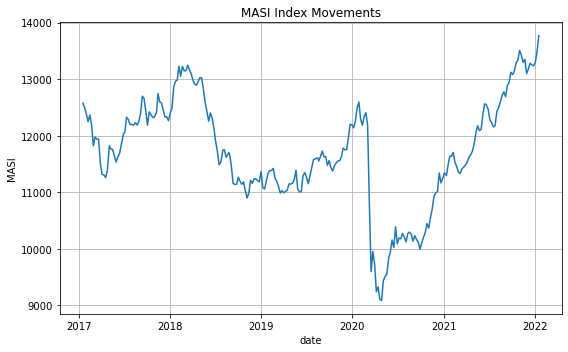

In [17]:
fig, ax = plt.subplots(figsize=(8, 5))
ax.plot(stocks_df.index, stocks_df["MASI"])
ax.grid()
ax.set_title('MASI Index Movements')
ax.set_ylabel('MASI')
ax.set_xlabel('date')
fig.tight_layout();

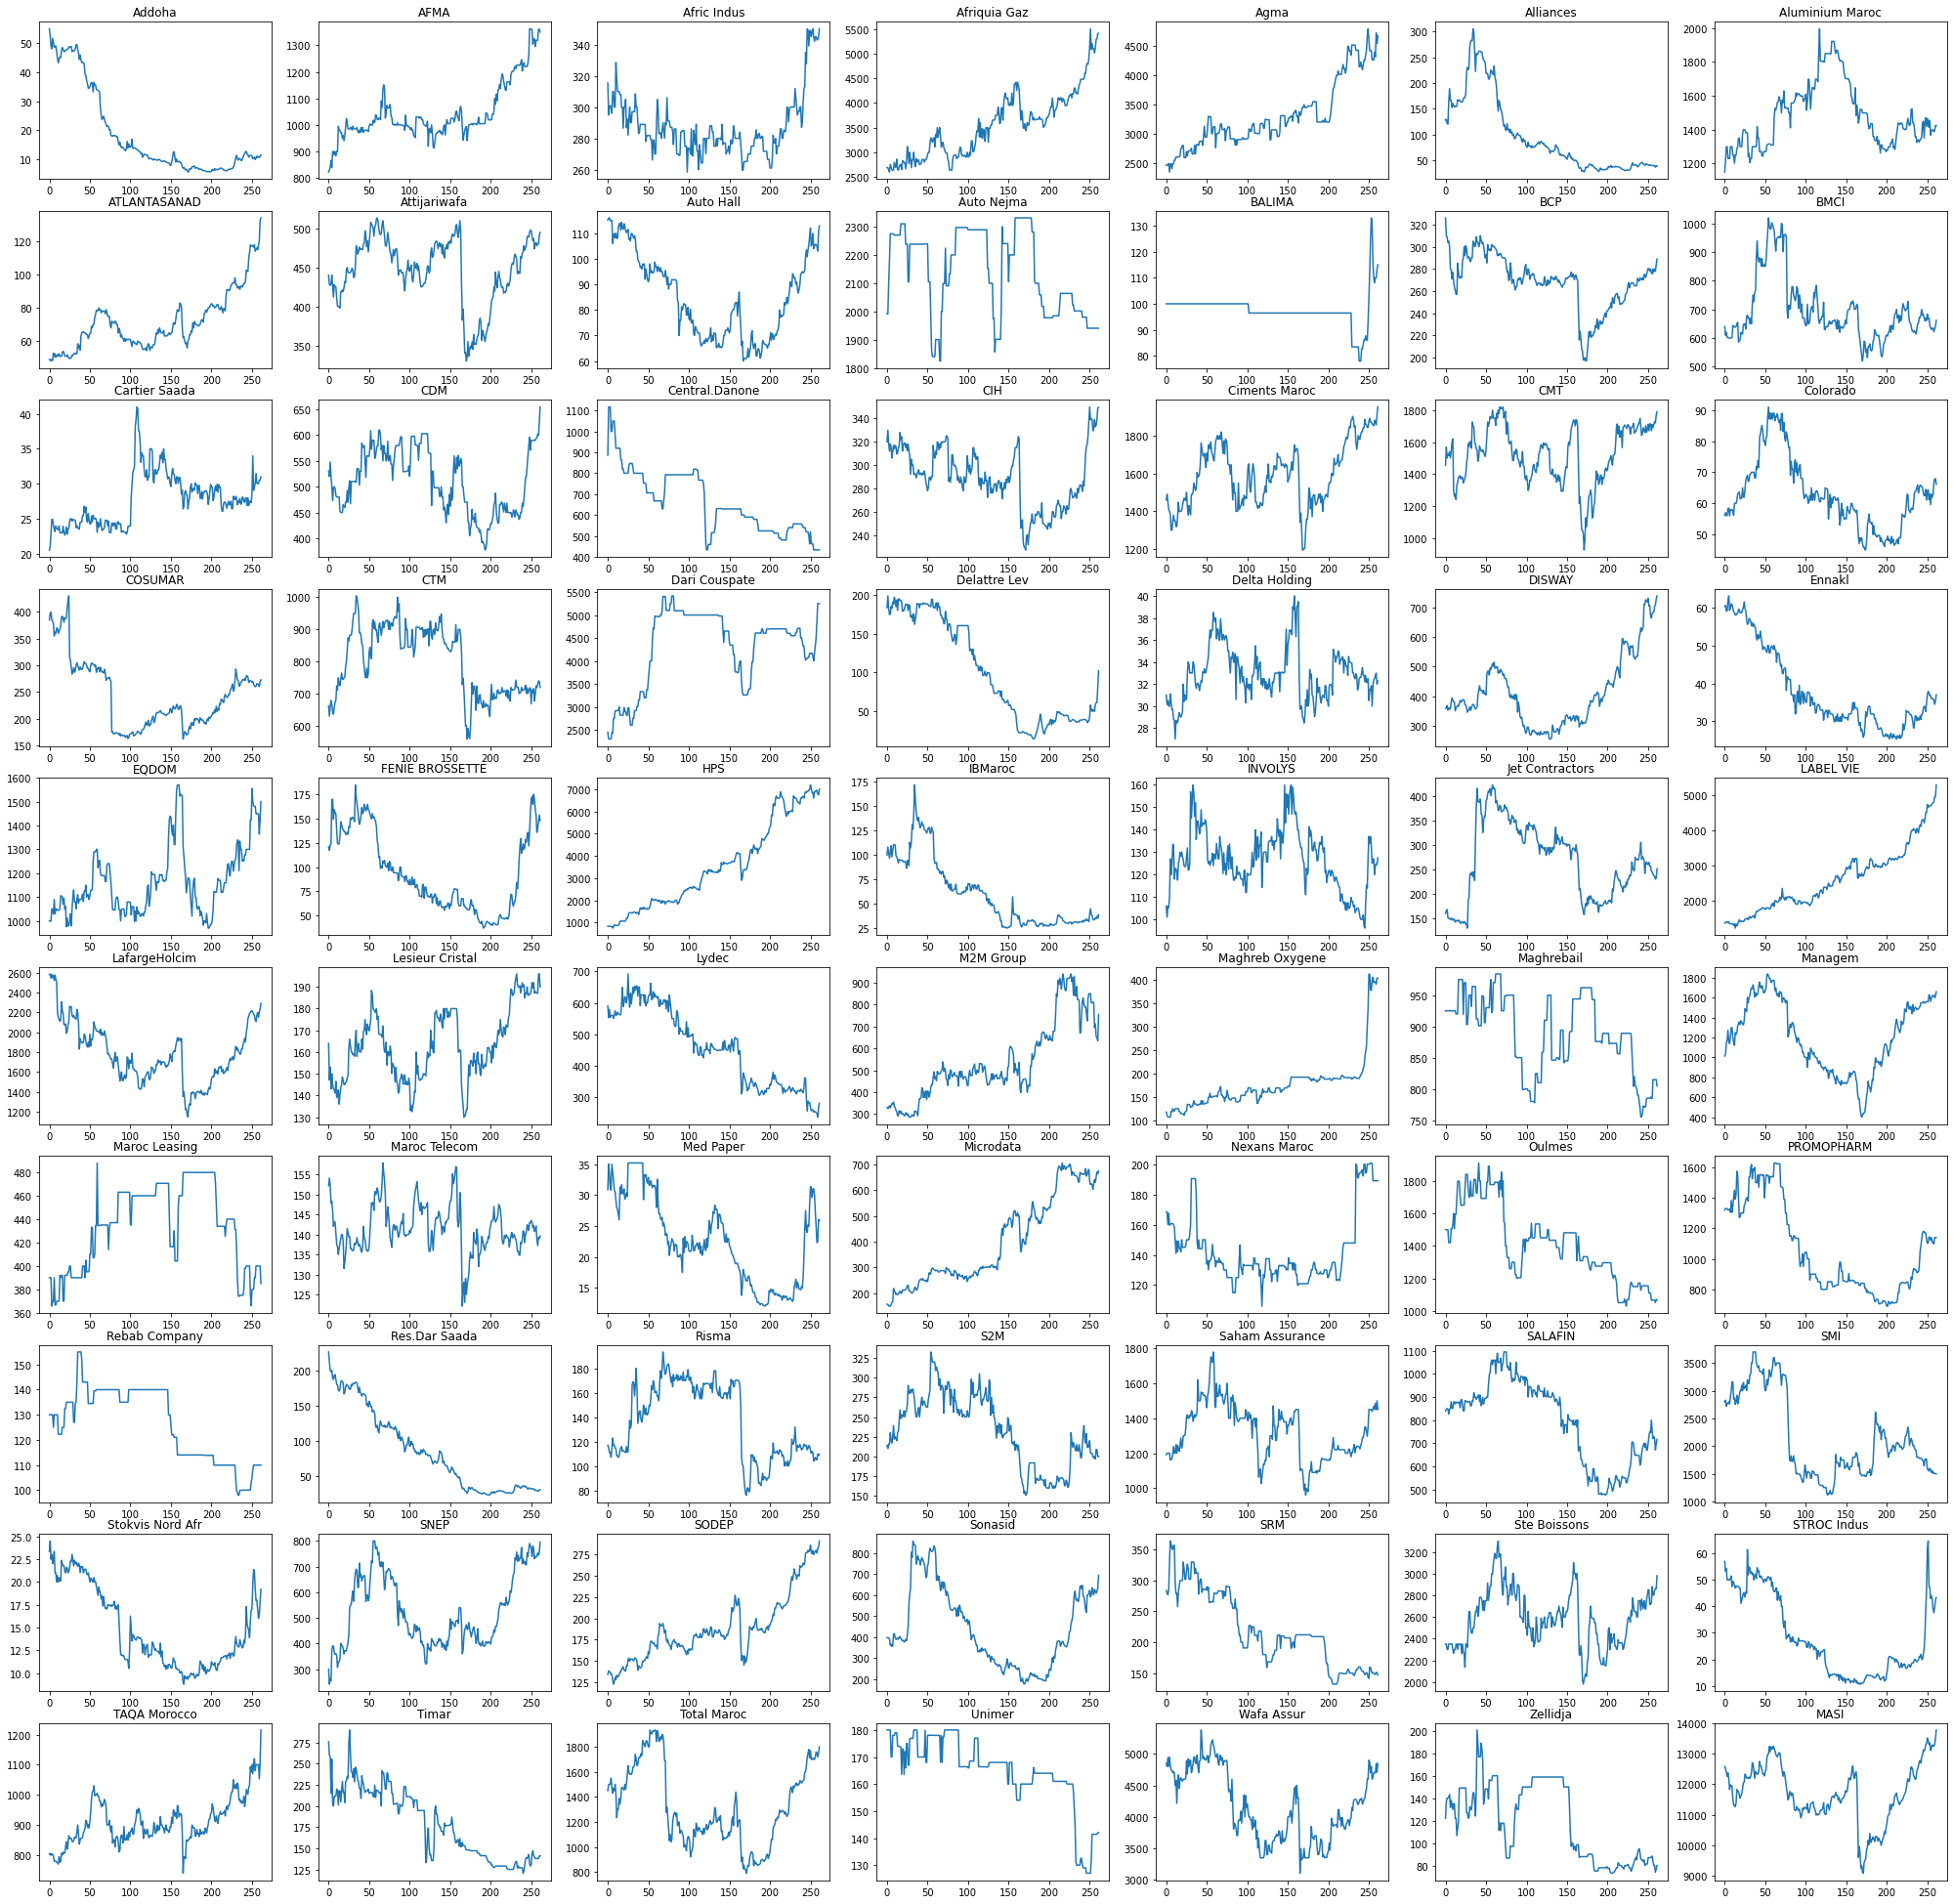

In [18]:
cols = stocks_df.columns

fig, axs = plt.subplots(10,7,figsize=(35,35))
for i in range(10):
    for j in range(7):
        axs[i, j].plot(stocks_df[cols[i*7+j]].values)
        axs[i, j].set_title(cols[i*7+j])
plt.show()

# Dimensionality Reduction

we can use PCA to reduce the number of stocks included in the analysis (I prefer not to)

In [19]:
if config.run_pca:
    n_components = 40
    pca = PCA(n_components)
    ts_pca = pca.fit_transform(np.array(stocks_df).reshape(stocks_df.shape[0], stocks_df.shape[1]))
    wandb.log({"pca_components" : pca.n_components_})
    n_pca = pca.n_components_
    most_important = [np.abs(pca.components_[i]).argmax() for i in range(n_pca)]
    initial_feature_names = stocks_df.columns
    most_important_names = list(set([initial_feature_names[most_important[i]] for i in range(n_pca)]))
    wandb.log({"important companies" : most_important_names})
    stocks = stocks_df[most_important_names]
else:
    stocks = stocks_df
    
cols = stocks.columns

# Clustering

In [20]:
ts = np.array(stocks.T).reshape(stocks.T.shape[0], stocks.T.shape[1], 1)
ts = TimeSeriesScalerMinMax().fit_transform(ts)

In [21]:
km = TimeSeriesKMeans(n_clusters = config.n_clusters, random_state = config.seed, metric = config.metric)
y_pred = km.fit_predict(ts)
s = silhouette_score(ts, y_pred, metric=config.metric)
print("K-means metrics : ")
print(f"Silhouette score = {s}, \nInertia = {km.inertia_}")

K-means metrics : 
Silhouette score = 0.351686894089539, 
Inertia = 1.0119381077919323


In [22]:
wandb.run.summary["n_clusters"] = km.n_clusters
wandb.run.summary["silhouette_score"] = s
wandb.run.summary["Inertia"] = km.inertia_

In [23]:
wandb.log({"n_clusters" : km.n_clusters})
wandb.log({"silhouette_score" : s})
wandb.log({"Inertia" : km.inertia_})

In [24]:
wandb.config.update({'labels' : km.cluster_centers_})

In [25]:
clusters_df = pd.DataFrame({'Company\'s stock':stocks.columns, 'Cluster': y_pred}).sort_values(by = 'Cluster')

In [26]:
clusters_df

,Company's stock,Cluster
20,Colorado,0
51,Risma,0
42,Maroc Leasing,0
33,Jet Contractors,0
32,INVOLYS,0
...,...,...
43,Maroc Telecom,3
41,Managem,3
40,Maghrebail,3
55,SMI,3


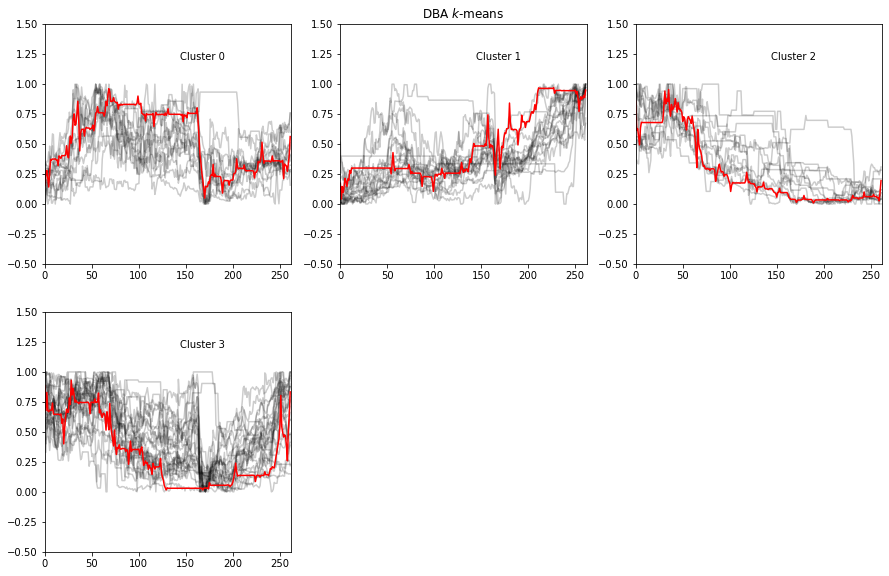

In [27]:
for yi in range(config.n_clusters):
    plt.subplot(3, 3, 4 + yi)
    for xx in ts[y_pred == yi]:
        plt.plot(xx.ravel(), "k-", alpha=.2)
    plt.plot(km.cluster_centers_[yi].ravel(), "r-")
    plt.xlim(0, ts.shape[1])
    plt.ylim(-.5, 1.5)
    plt.text(0.55, 0.85,'Cluster %d' % (yi),
             transform=plt.gca().transAxes)
    plt.gcf().set_size_inches(15, 15)
    if yi == 1:
        plt.title("DBA $k$-means")


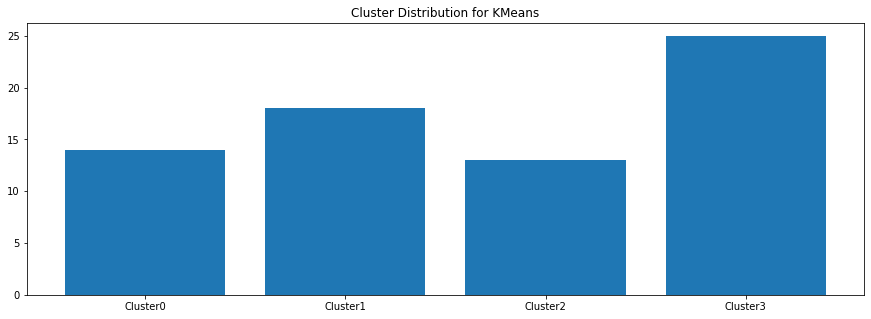

In [28]:
cluster_c = clusters_df["Cluster"].value_counts().sort_index()
cluster_n = [f"Cluster{str(i)}" for i in range(km.n_clusters)]
fig, ax = plt.subplots(1, 1,figsize=(15,5))
ax.set_title("Cluster Distribution for KMeans")
ax.bar(cluster_n, cluster_c)
plt.show()
wandb.log({"time series clustered": fig})

In [29]:
len(cols)

70

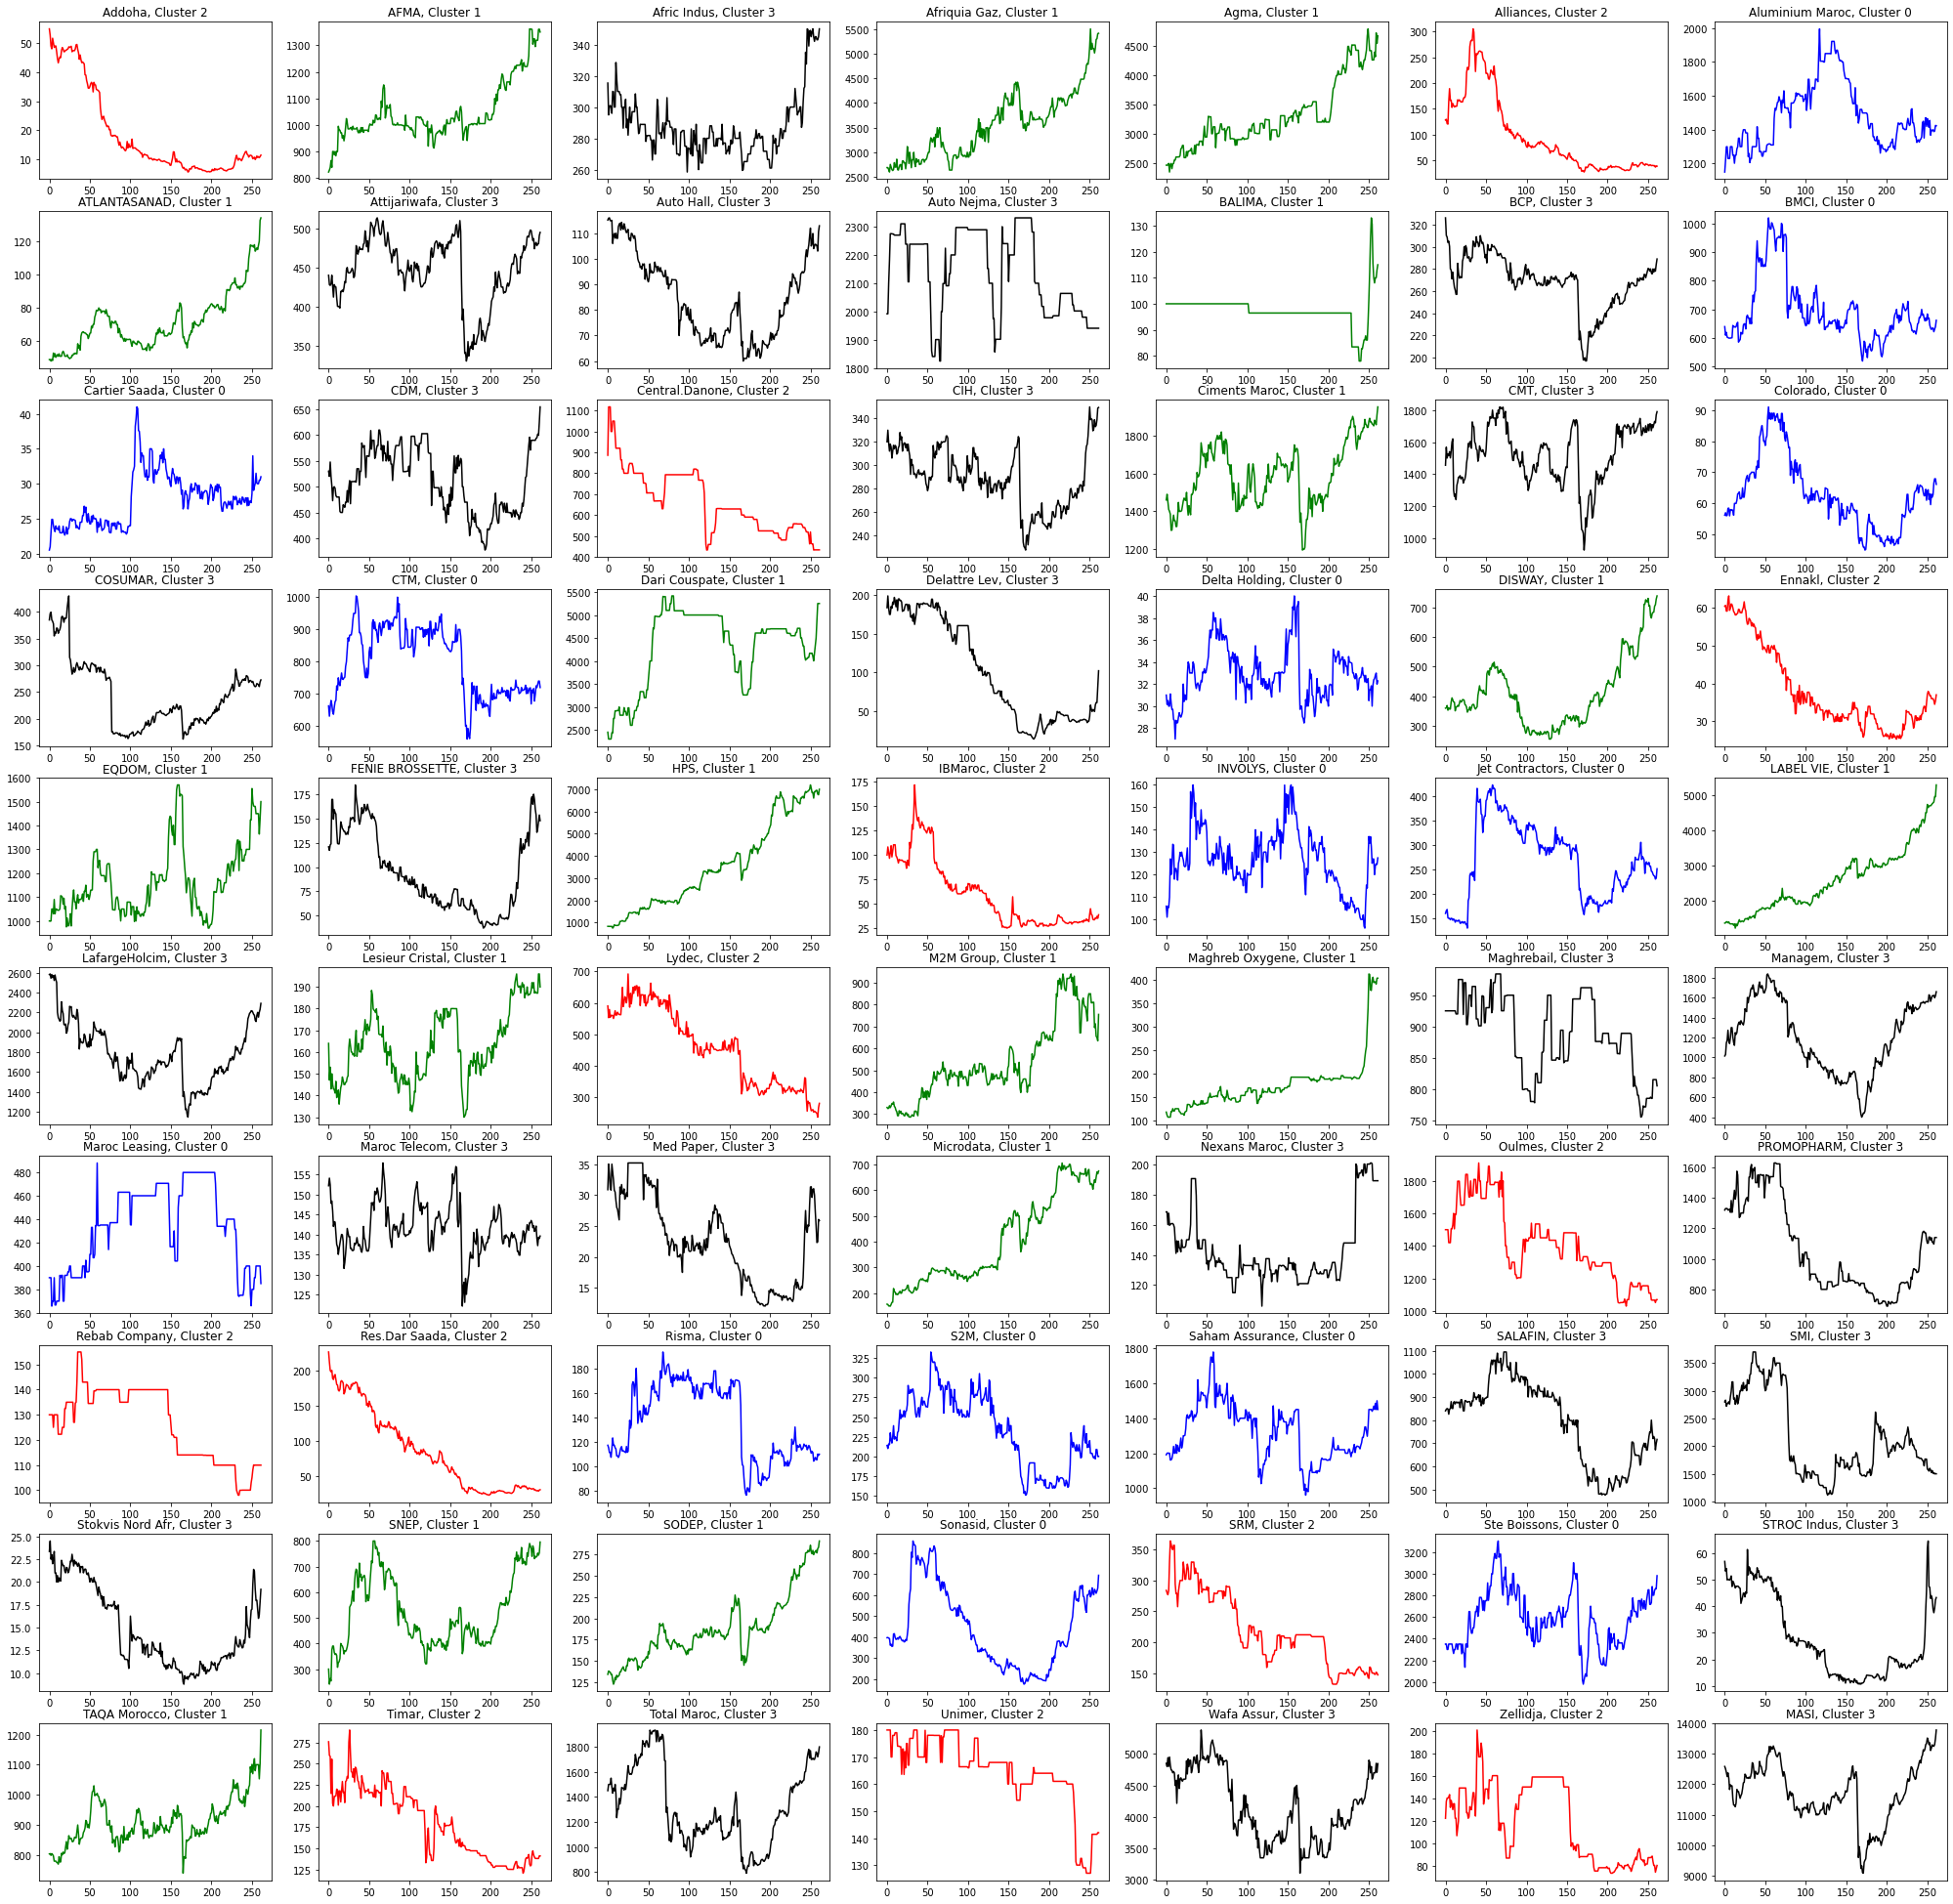

In [30]:
colors = ['b', 'g','r', 'k', 'orange', 'brown', 'y']

if config.run_pca:
    x = 10
    y = 5
else:
    x = 10
    y = 7

fig, ax = plt.subplots(x, y,figsize=(35,35))
for i in range(x):
    for j in range(y):
        try:
            ax[i, j].plot(stocks[cols[i*y+j]].values, color = colors[y_pred[i*y+j]])
            ax[i, j].set_title(f"{cols[i*y+j]}, Cluster {y_pred[i*y+j]}")
        except:
            fig.delaxes(ax[i, j])
            continue

plt.show()

# Conclusion

as we can see from the chart our algorithm did pretty well seperating stocks according to these patterns:
* Trending downward
* Trending upward
* Recovering from the pandemic
* Peaked during the pandemic

In [31]:
wandb.finish()

Inertia,▁
n_clusters,▁
silhouette_score,▁
Inertia,1.01194
n_clusters,4
silhouette_score,0.35169
